# <center>Lab Sheet 6</center>
# <center>Backpropagation & Derivatives</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

# Print the name and roll number
print("Name: Somesh Singh")
print("Roll Number: 233025921")

Name: Somesh Singh
Roll Number: 233025921


# --------- Utilities ---------

In [2]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-x))


def sigmoid_deriv_from_preact(z: np.ndarray) -> np.ndarray:
    s = sigmoid(z)
    return s * (1 - s)

# Print the name and roll number
print("Name: Somesh Singh")
print("Roll Number: 233025921")

def mse_loss(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    return float(np.mean((y_pred - y_true) ** 2))


def mse_grad(y_pred: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    # gradient of MSE w.r.t. y_pred (elementwise)
    return 2 * (y_pred - y_true) / y_true.size

Name: Somesh Singh
Roll Number: 233025921


**Q1. Manually implement backpropagation algorithm for a 3-layer MLP.**

In [3]:
class ManualMLP:
    """Simple 1-hidden-layer MLP for regression (identity output)
    Architecture: input_dim -> hidden_dim (sigmoid) -> output_dim
    """
    def __init__(self, input_dim:int, hidden_dim:int, output_dim:int, seed:int=0, init_scale:float=0.5):
        rng = np.random.RandomState(seed)
        self.W1 = rng.randn(hidden_dim, input_dim) * init_scale
        self.b1 = np.zeros((hidden_dim, 1))
        self.W2 = rng.randn(output_dim, hidden_dim) * init_scale
        self.b2 = np.zeros((output_dim, 1))
        # gradient placeholders
        self.grads = {}
        
        # Print the name and roll number
        print("Name: Somesh Singh")
        print("Roll Number: 233025921")
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        # X shape: (input_dim, batch)
        self.X = X
        self.Z1 = self.W1.dot(X) + self.b1   # pre-activation hidden
        self.A1 = sigmoid(self.Z1)           # activation hidden
        self.Z2 = self.W2.dot(self.A1) + self.b2  # pre-activation output
        self.A2 = self.Z2  # identity output
        return self.A2

    def compute_loss(self, Y_pred: np.ndarray, Y_true: np.ndarray) -> float:
        return mse_loss(Y_pred, Y_true)

    def backward(self, Y_true: np.ndarray) -> dict:
        # Y_true shape: (output_dim, batch)
        m = Y_true.shape[1]
        dA2 = mse_grad(self.A2, Y_true)  # (output_dim, batch)
        dZ2 = dA2  # identity derivative
        dW2 = (1.0/m) * dZ2.dot(self.A1.T)
        db2 = (1.0/m) * np.sum(dZ2, axis=1, keepdims=True)
        dA1 = self.W2.T.dot(dZ2)
        dZ1 = dA1 * sigmoid_deriv_from_preact(self.Z1)
        dW1 = (1.0/m) * dZ1.dot(self.X.T)
        db1 = (1.0/m) * np.sum(dZ1, axis=1, keepdims=True)
        self.grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
        return self.grads

    def step(self, lr:float=0.1):
        self.W1 -= lr * self.grads['dW1']
        self.b1 -= lr * self.grads['db1']
        self.W2 -= lr * self.grads['dW2']
        self.b2 -= lr * self.grads['db2']

**Q2. Derive and verify gradients using symbolic differentiation (SymPy).**

In [4]:
def symbolic_gradients_example():
    try:
        import sympy as sp
    except ImportError:
        print("SymPy not installed — skipping symbolic differentiation.")
        return None

        # Print the name and roll number
        print("Name: Somesh Singh")
        print("Roll Number: 233025921")

    # Define symbols
    x, w1, b1, w2, b2, y_true = sp.symbols('x w1 b1 w2 b2 y_true', real=True)
    z1 = w1 * x + b1
    a1 = 1 / (1 + sp.exp(-z1))  # sigmoid
    z2 = w2 * a1 + b2
    y_pred = z2
    loss = (y_pred - y_true) ** 2  # single-sample MSE

    dloss_dw2 = sp.simplify(sp.diff(loss, w2))
    dloss_db2 = sp.simplify(sp.diff(loss, b2))
    dloss_dw1 = sp.simplify(sp.diff(loss, w1))
    dloss_db1 = sp.simplify(sp.diff(loss, b1))

    return {
        'dloss_dw2': dloss_dw2,
        'dloss_db2': dloss_db2,
        'dloss_dw1': dloss_dw1,
        'dloss_db1': dloss_db1,
    }

**Q3. Train the model on small dataset and plot gradient flow through layers.**

In [5]:
def make_sine_dataset(n_samples:int=200, noise:float=0.1, seed:int=1):
    rng = np.random.RandomState(seed)
    X = rng.uniform(-1, 1, (1, n_samples))
    Y = np.sin(2 * np.pi * X) + noise * rng.randn(1, n_samples)
    return X, Y

# Print the name and roll number
print("Name: Somesh Singh")
print("Roll Number: 233025921")

def train_manual_mlp():
    # dataset
    X, Y = make_sine_dataset()
    # train/test split
    split = int(0.8 * X.shape[1])
    X_train, Y_train = X[:, :split], Y[:, :split]
    X_test, Y_test = X[:, split:], Y[:, split:]

    # model
    model = ManualMLP(input_dim=1, hidden_dim=10, output_dim=1, seed=42, init_scale=0.5)

    epochs = 600
    lr = 0.5
    grad_norms = {'dW1': [], 'dW2': [], 'db1': [], 'db2': []}
    losses = []

    for ep in range(epochs):
        y_pred = model.forward(X_train)
        loss = model.compute_loss(y_pred, Y_train)
        model.backward(Y_train)
        # record norms
        for k, v in model.grads.items():
            grad_norms[k].append(float(np.linalg.norm(v)))
        losses.append(loss)
        model.step(lr)

    # evaluate test
    y_test_pred = model.forward(X_test)
    test_loss = model.compute_loss(y_test_pred, Y_test)

    # plots
    plt.figure(figsize=(8,4))
    plt.plot(grad_norms['dW1'], label='||dW1||')
    plt.plot(grad_norms['dW2'], label='||dW2||')
    plt.plot(grad_norms['db1'], label='||db1||')
    plt.plot(grad_norms['db2'], label='||db2||')
    plt.title('Gradient L2 norms across epochs (manual MLP)')
    plt.xlabel('Epoch')
    plt.ylabel('L2 norm')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,3))
    plt.plot(losses)
    plt.title('Training loss (manual MLP)')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.tight_layout()
    plt.show()

    print(f"Final train loss: {losses[-1]:.6f}; Test loss: {test_loss:.6f}")
    return model, (X_train, Y_train, X_test, Y_test), grad_norms, losses

Name: Somesh Singh
Roll Number: 233025921


**Q4. Show impact of vanishing gradients using deep Sigmoid networks.**

In [6]:
def init_deep_sigmoid(layer_sizes: List[int], scale:float=0.5, seed:int=0):
    rng = np.random.RandomState(seed)
    params = []
    for i in range(len(layer_sizes)-1):
        W = rng.randn(layer_sizes[i+1], layer_sizes[i]) * scale
        b = np.zeros((layer_sizes[i+1], 1))
        params.append({'W': W, 'b': b})
    return params


def forward_deep(params: List[dict], X: np.ndarray):
    activations = [X]
    preacts = []
    A = X
    for layer in params:
        Z = layer['W'].dot(A) + layer['b']
        preacts.append(Z)
        A = sigmoid(Z)
        activations.append(A)
    return activations, preacts


# Print the name and roll number
print("Name: Somesh Singh")
print("Roll Number: 233025921")

def backward_deep(params: List[dict], activations: List[np.ndarray], preacts: List[np.ndarray], Y: np.ndarray):
    m = Y.shape[1]
    L = len(params)
    grads = [None] * L
    A_L = activations[-1]
    dA = mse_grad(A_L, Y)
    for l in reversed(range(L)):
        Z = preacts[l]
        A_prev = activations[l]
        dZ = dA * sigmoid_deriv_from_preact(Z)
        dW = (1.0/m) * dZ.dot(A_prev.T)
        db = (1.0/m) * np.sum(dZ, axis=1, keepdims=True)
        grads[l] = {'dW': dW, 'db': db}
        dA = params[l]['W'].T.dot(dZ)
    return grads


def vanishing_gradients_demo(depth:int=20, width:int=8):
    X, Y = make_sine_dataset(n_samples=160)  # use training-ish data
    layer_sizes = [1] + [width] * depth + [1]
    params = init_deep_sigmoid(layer_sizes, scale=0.5, seed=7)
    activations, preacts = forward_deep(params, X)
    grads = backward_deep(params, activations, preacts, Y)
    grad_norms = [float(np.linalg.norm(g['dW'])) for g in grads]

    # print a summary (first 10 and last 3)
    print('Gradient norms (dW) per layer — showing first 10 and last 3:')
    for i, gn in enumerate(grad_norms[:10]):
        print(f"Layer {i+1} dW norm: {gn:.6e}")
    print('...')
    for i, gn in enumerate(grad_norms[-3:], start=len(grad_norms)-2):
        print(f"Layer {i+1} dW norm: {gn:.6e}")

    # plot across layers
    plt.figure(figsize=(8,4))
    plt.plot(range(1, len(grad_norms)+1), grad_norms, marker='o')
    plt.title('Vanishing gradients: gradient norms across deep sigmoid network')
    plt.xlabel('Layer index (input -> output)')
    plt.ylabel('L2 norm of dW')
    plt.tight_layout()
    plt.show()

    return grad_norms

Name: Somesh Singh
Roll Number: 233025921


**Q5. Use TensorFlow or PyTorch to replicate the same model and compare gradients.**

In [7]:
def pytorch_compare(manual_model: ManualMLP, X_np: np.ndarray, Y_np: np.ndarray):
    try:
        import torch
        import torch.nn as nn
    except ImportError:
        print('PyTorch not installed — skipping PyTorch comparison.')
        return None

    class TorchMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(1, manual_model.W1.shape[0])
            self.act = nn.Sigmoid()
            self.fc2 = nn.Linear(manual_model.W1.shape[0], 1)
        def forward(self, x):
            x = self.fc1(x)
            x = self.act(x)
            x = self.fc2(x)
            return x

    t_model = TorchMLP()
    # copy weights
    with torch.no_grad():
        t_model.fc1.weight.copy_(torch.tensor(manual_model.W1, dtype=torch.float32))
        t_model.fc1.bias.copy_(torch.tensor(manual_model.b1.flatten(), dtype=torch.float32))
        t_model.fc2.weight.copy_(torch.tensor(manual_model.W2, dtype=torch.float32))
        t_model.fc2.bias.copy_(torch.tensor(manual_model.b2.flatten(), dtype=torch.float32))

    # prepare batch of size <= available
    batch = min(32, X_np.shape[1])
    X_batch = torch.tensor(X_np[:, :batch].T, dtype=torch.float32)  # shape (batch, in)
    Y_batch = torch.tensor(Y_np[:, :batch].T, dtype=torch.float32)

    t_model.zero_grad()
    out = t_model(X_batch)
    loss_fn = nn.MSELoss()
    loss = loss_fn(out, Y_batch)
    loss.backward()

    torch_grads = {
        'dW1': t_model.fc1.weight.grad.detach().numpy().copy(),
        'db1': t_model.fc1.bias.grad.detach().numpy().copy(),
        'dW2': t_model.fc2.weight.grad.detach().numpy().copy(),
        'db2': t_model.fc2.bias.grad.detach().numpy().copy(),
    }
    torch_summary = {k: float(np.linalg.norm(v)) for k, v in torch_grads.items()}

    # manual grads on same batch
    _ = manual_model.forward(X_np[:, :batch])
    manual_grads = manual_model.backward(Y_np[:, :batch])
    manual_summary = {k: float(np.linalg.norm(v)) for k, v in manual_grads.items()}

    print('\nPyTorch gradient norms (L2)')
    for k, v in torch_summary.items():
        print(f"{k}: {v:.6e}")
    print('\nManual gradient norms (L2) on same batch')
    for k, v in manual_summary.items():
        print(f"{k}: {v:.6e}")

    # bar chart comparison
    keys = ['dW1', 'dW2', 'db1', 'db2']
    manual_vals = [manual_summary[k] for k in keys]
    torch_vals = [torch_summary[k] for k in keys]

    x = np.arange(len(keys))
    width = 0.35
    plt.figure(figsize=(7,3))
    plt.bar(x - width/2, manual_vals, width=width, label='Manual')
    plt.bar(x + width/2, torch_vals, width=width, label='PyTorch')
    plt.xticks(x, keys)
    plt.ylabel('L2 norm')
    plt.title('Gradient norm comparison — Manual vs PyTorch')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return torch_summary, manual_summary


# Print the name and roll number
print("Name: Somesh Singh")
print("Roll Number: 233025921")

def tensorflow_compare(manual_model: ManualMLP, X_np: np.ndarray, Y_np: np.ndarray):
    try:
        import tensorflow as tf
    except ImportError:
        print('TensorFlow not installed — skipping TensorFlow comparison.')
        return None

    # Build a tiny model in TF keras
    tf.random.set_seed(0)
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1,)),
        tf.keras.layers.Dense(manual_model.W1.shape[0], activation='sigmoid', use_bias=True),
        tf.keras.layers.Dense(1, activation='linear', use_bias=True)
    ])

    # set weights from manual model
    # Keras Dense weights format: [kernel, bias] with kernel shape (in_dim, out_dim)
    # Our manual W1 is (hidden, in); need to transpose
    w1_tf = manual_model.W1.T.copy()
    b1_tf = manual_model.b1.flatten().copy()
    w2_tf = manual_model.W2.T.copy()
    b2_tf = manual_model.b2.flatten().copy()

    model.layers[0].set_weights([w1_tf, b1_tf])
    model.layers[1].set_weights([w2_tf, b2_tf])

    # run a forward/backward with GradientTape
    batch = min(32, X_np.shape[1])
    X_batch = X_np[:, :batch].T  # shape (batch, in)
    Y_batch = Y_np[:, :batch].T

    X_tf = tf.convert_to_tensor(X_batch, dtype=tf.float32)
    Y_tf = tf.convert_to_tensor(Y_batch, dtype=tf.float32)

    with tf.GradientTape() as tape:
        preds = model(X_tf, training=True)
        loss = tf.reduce_mean(tf.square(preds - Y_tf))
    grads = tape.gradient(loss, model.trainable_variables)

    # grads ordering: [dense1_kernel, dense1_bias, dense2_kernel, dense2_bias]
    tf_summary = {
        'dW1': float(tf.norm(grads[0]).numpy()),
        'db1': float(tf.norm(grads[1]).numpy()),
        'dW2': float(tf.norm(grads[2]).numpy()),
        'db2': float(tf.norm(grads[3]).numpy()),
    }

    # manual grads
    _ = manual_model.forward(X_np[:, :batch])
    manual_grads = manual_model.backward(Y_np[:, :batch])
    manual_summary = {k: float(np.linalg.norm(v)) for k, v in manual_grads.items()}

    print('\nTensorFlow gradient norms (L2)')
    for k, v in tf_summary.items():
        print(f"{k}: {v:.6e}")
    print('\nManual gradient norms (L2) on same batch')
    for k, v in manual_summary.items():
        print(f"{k}: {v:.6e}")

    # comparison plot
    keys = ['dW1', 'dW2', 'db1', 'db2']
    manual_vals = [manual_summary[k] for k in keys]
    tf_vals = [tf_summary[k] for k in keys]

    x = np.arange(len(keys))
    width = 0.35
    plt.figure(figsize=(7,3))
    plt.bar(x - width/2, manual_vals, width=width, label='Manual')
    plt.bar(x + width/2, tf_vals, width=width, label='TensorFlow')
    plt.xticks(x, keys)
    plt.ylabel('L2 norm')
    plt.title('Gradient norm comparison — Manual vs TensorFlow')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return tf_summary, manual_summary

Name: Somesh Singh
Roll Number: 233025921


# --------- Main runner for the lab ---------

--- Lab Sheet 6: Backpropagation & Derivatives ---
Name: Somesh Singh
Roll Number: 233025921


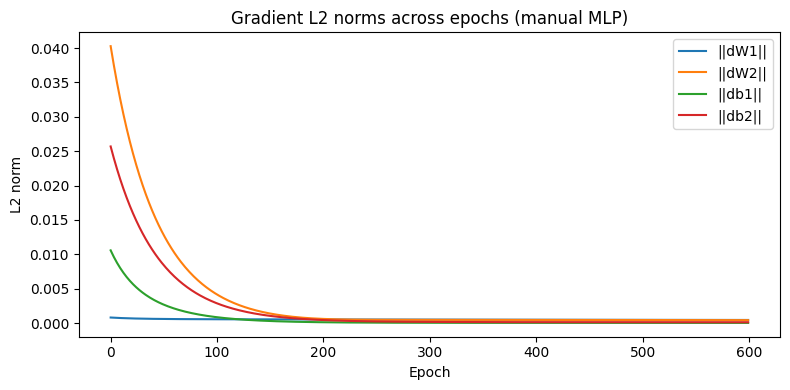

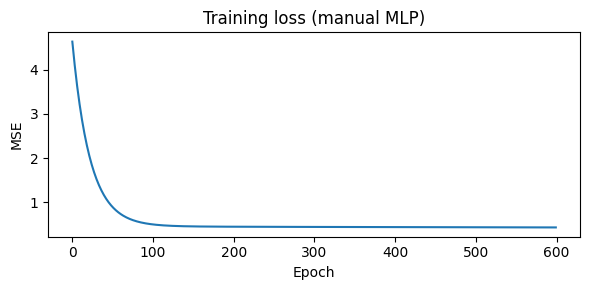

Final train loss: 0.428725; Test loss: 0.422481

Symbolic gradients (example expressions):
dloss_dw2 = (w2*exp(b1 + w1*x) + (b2 - y_true)*(exp(b1 + w1*x) + 1))/(2*cosh(b1/2 + w1*x/2)**2)

dloss_db2 = 2*(w2*exp(b1 + w1*x) + (b2 - y_true)*(exp(b1 + w1*x) + 1))/(exp(b1 + w1*x) + 1)

dloss_dw1 = 2*w2*x*(w2*exp(b1 + w1*x) + (b2 - y_true)*(exp(b1 + w1*x) + 1))*exp(b1 + w1*x)/(exp(b1 + w1*x) + 1)**3

dloss_db1 = 2*w2*(w2*exp(b1 + w1*x) + (b2 - y_true)*(exp(b1 + w1*x) + 1))*exp(b1 + w1*x)/(exp(b1 + w1*x) + 1)**3

Name: Somesh Singh
Roll Number: 233025921

Running vanishing gradients demo (deep sigmoid)...
Gradient norms (dW) per layer — showing first 10 and last 3:
Layer 1 dW norm: 6.790632e-15
Layer 2 dW norm: 7.760766e-14
Layer 3 dW norm: 2.322543e-13
Layer 4 dW norm: 1.031003e-12
Layer 5 dW norm: 3.373590e-12
Layer 6 dW norm: 1.115762e-11
Layer 7 dW norm: 3.266355e-11
Layer 8 dW norm: 1.157072e-10
Layer 9 dW norm: 3.905237e-10
Layer 10 dW norm: 9.733448e-10
...
Layer 20 dW norm: 1.163504e-0

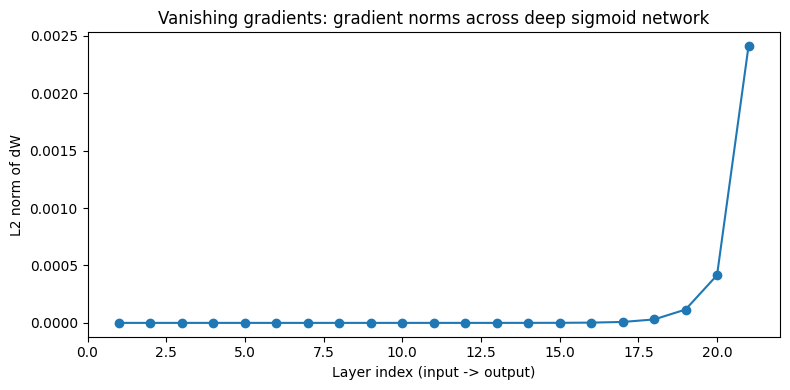


PyTorch gradient norms (L2)
dW1: 9.203947e-02
db1: 4.663504e-02
dW2: 2.932934e-01
db2: 1.433563e-01

Manual gradient norms (L2) on same batch
dW1: 2.876233e-03
db1: 1.457346e-03
dW2: 9.165423e-03
db2: 4.479887e-03


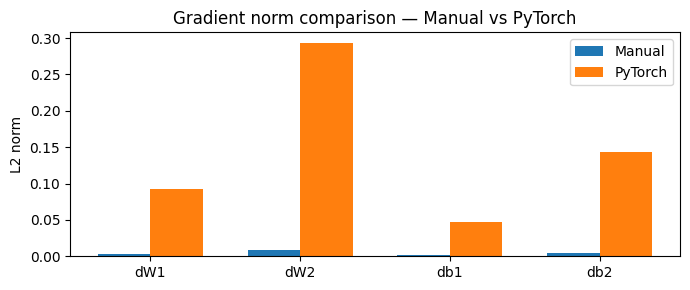

2025-10-02 05:37:28.003065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759383448.294016      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759383448.367388      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-10-02 05:37:49.868895: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



TensorFlow gradient norms (L2)
dW1: 9.203947e-02
db1: 4.663505e-02
dW2: 2.932934e-01
db2: 1.433563e-01

Manual gradient norms (L2) on same batch
dW1: 2.876233e-03
db1: 1.457346e-03
dW2: 9.165423e-03
db2: 4.479887e-03


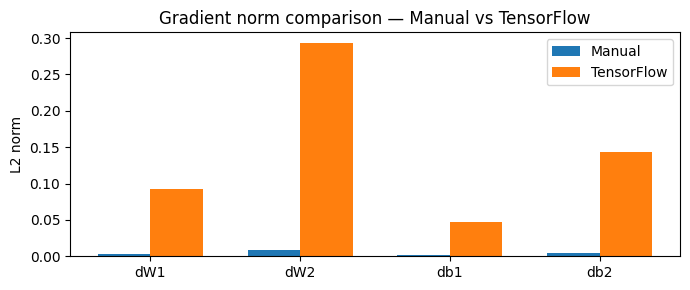


Finished lab script. Modify depths, widths, and init scales to experiment further.


In [8]:
if __name__ == '__main__':
    print('--- Lab Sheet 6: Backpropagation & Derivatives ---')

    # 1+3: train manual MLP and show gradient flow
    manual_model, data, grad_norms, losses = train_manual_mlp()

    # 2: symbolic gradients
    sym_res = symbolic_gradients_example()
    if sym_res is not None:
        print('\nSymbolic gradients (example expressions):')
        for k,v in sym_res.items():
            print(f"{k} = {v}\n")
            
        # Print the name and roll number
        print("Name: Somesh Singh")
        print("Roll Number: 233025921")

    # 4: vanishing gradients demo
    print('\nRunning vanishing gradients demo (deep sigmoid)...')
    vanishing_grad_norms = vanishing_gradients_demo(depth=20, width=8)

    # 5: try PyTorch compare
    X_train, Y_train, X_test, Y_test = data
    try:
        pytorch_compare(manual_model, X_train, Y_train)
    except Exception as e:
        print('PyTorch comparison failed or not available:', e)

    # 5b: try TensorFlow compare
    try:
        tensorflow_compare(manual_model, X_train, Y_train)
    except Exception as e:
        print('TensorFlow comparison failed or not available:', e)

    print('\nFinished lab script. Modify depths, widths, and init scales to experiment further.')